In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os

In [19]:
# List of all the lineages we will be making dataframes for - some of the DFs don't have a col named depmapid but have depmapids, will require some cleaning
lineages = ["kidney", "breast", "blood", "liver", "urinary_tract", "colorectal", "ovary", "pancreas"]
lineage_df_dict = {}

In [20]:
# List of all the feature dataframes we are going to read into the lineage dataframes
features = ["effect", "dependency", "expression", "gene_cn"]
feature_df_dict = {}

In [21]:
sample_info_df = pd.read_csv('data/sample_info.csv')

In [22]:
folder_path = "data/"

for file_name in os.listdir(folder_path):
    for feature in features:
        if file_name.endswith('.csv') and feature in file_name:
            file_path = os.path.join(folder_path, file_name)
            feature_df_dict[feature] = pd.read_csv(file_path)
            feature_df_dict[feature].columns = [column.split(' ')[0] for column in feature_df_dict[feature].columns]
            feature_df_dict[feature].rename(columns={feature_df_dict[feature].columns[0]: "DepMap_ID"}, inplace=True)
            feature_df_dict[feature] = pd.merge(feature_df_dict[feature], sample_info_df[['DepMap_ID', 'lineage']], on='DepMap_ID', how='left')
            feature_df_dict[feature].drop("DepMap_ID", axis=1, inplace=True)
            feature_df_dict[feature] = feature_df_dict[feature].pivot_table(index='lineage', aggfunc='mean')

In [23]:
for feature in features:
    for lineage in lineages:
        temp_df = feature_df_dict[feature].loc[feature_df_dict[feature].index == lineage].transpose()
        temp_df.index.name = 'gene'
        if lineage in lineage_df_dict:
            temp_df.rename(columns={lineage : feature}, inplace=True)
            lineage_df_dict[lineage] = pd.merge(lineage_df_dict[lineage], temp_df, on="gene", how="outer").dropna()
        else:
            lineage_df_dict[lineage] = pd.DataFrame({feature: temp_df[lineage]}, index=temp_df.index)
            lineage_df_dict[lineage].index.name = 'gene'
            lineage_df_dict[lineage].reset_index(inplace=True)

In [24]:
lineage_df_dict['colorectal']

,gene,effect,dependency,expression,gene_cn
0,A1BG,-0.015041,0.043599,0.590738,1.020882
2,A1CF,-0.068805,0.083945,1.262503,1.019519
3,A2M,0.001877,0.035082,0.285868,1.105415
5,A2ML1,0.034582,0.030788,0.309722,1.105017
9,A3GALT2,-0.046617,0.062978,0.009425,0.895263
...,...,...,...,...,...
59260,ZYG11A,-0.020647,0.046334,0.178135,0.892073
59262,ZYG11B,-0.094004,0.087456,2.296709,0.892073
59263,ZYX,-0.015553,0.045229,6.060374,1.218197
59265,ZZEF1,-0.065964,0.070773,3.277261,0.920887


In [25]:
training_dfs = {}
training_lineages = {"kidney" : "kidney", 
                     "breast" : "breast", 
                     "leukemia" : "blood", 
                     "liver" : "liver", 
                     "bladder" : "urinary_tract",
                     "colon" : "colorectal", 
                     "ovarian" : "ovary", 
                     "pancreatic" : "pancreas"}
for k, v in training_lineages.items():
    df = pd.read_csv(f"training_sets_genes/{k}_training_genes_set.csv")
    df = df.merge(lineage_df_dict[v], on="gene", how='left').fillna(0)
    lineage_df_dict[v] = pd.merge(lineage_df_dict[v], df, indicator=True, how='left', on=list(lineage_df_dict[v].columns)).query('_merge == "left_only"').drop('_merge', axis=1)
    training_dfs[k] = df

## Principal Component Analysis (PCA)

## Random Forest

## Neural Network

## Support Vector Machine (SVM)

## Logistic Regression

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, roc_curve, precision_score, recall_score, f1_score

In [88]:
def trainLRmodel(X, Y):
    # Get the training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    # Fit the model
    model = LogisticRegression().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_rt = model.predict_proba(X_test)[:, 1]

    accuracy = str(accuracy_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_rt, pos_label=1)
    auc_value = str(auc(fpr, tpr))
    precision = str(precision_score(y_test, y_pred, pos_label='positive'))
    recall = str(recall_score(y_test, y_pred, pos_label='positive'))
    f1score = str(f1_score(y_test, y_pred, average="weighted"))

    # print(f"Lineage: {lineage}\n\n")
    # print(f"Accuracy: {accuracy}\n\n")
    # print(f"Y Test: {y_test}\n\n")
    # print(f"Y Pred: {y_pred}\n\n")
    # print(f"Y Pred RT: {y_pred_rt}\n\n")
    # print(f"Accuracy: {accuracy}\n\n")
    # print(f"AUC: {auc_value}\n\n")
    # print(f"Precision: {precision}\n\n")
    # print(f"Recall: {recall}\n\n")
    # print(f"F1 Score: {f1score}\n\n")

    return [accuracy, y_test, y_pred, y_pred_rt, model, auc_value, precision, recall, f1score]


In [81]:
training_dfs['kidney']

,gene,label,effect,dependency,expression,gene_cn
0,PLK4,positive,-0.984314,0.863918,3.640710,0.860872
1,CTLA4,positive,0.034809,0.029048,0.069394,1.026365
2,FLT3,positive,-0.081378,0.075911,0.310125,0.893372
3,LCK,positive,0.038377,0.035519,0.153196,0.906288
4,FLT1,positive,0.043289,0.025756,0.050356,0.893385
...,...,...,...,...,...,...
219,EFNA3,negative,-0.191222,0.191477,2.003700,1.147023
220,HIST1H4L,negative,0.000000,0.000000,0.000000,0.000000
221,CRYGS,negative,-0.041804,0.051119,1.347271,1.095788
222,RAB10,negative,-0.432176,0.453347,6.329839,1.033599


In [73]:
import matplotlib.pyplot as plt
training_dfs.keys()

dict_keys(['kidney', 'breast', 'leukemia', 'liver', 'bladder', 'colon', 'ovarian', 'pancreatic'])

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

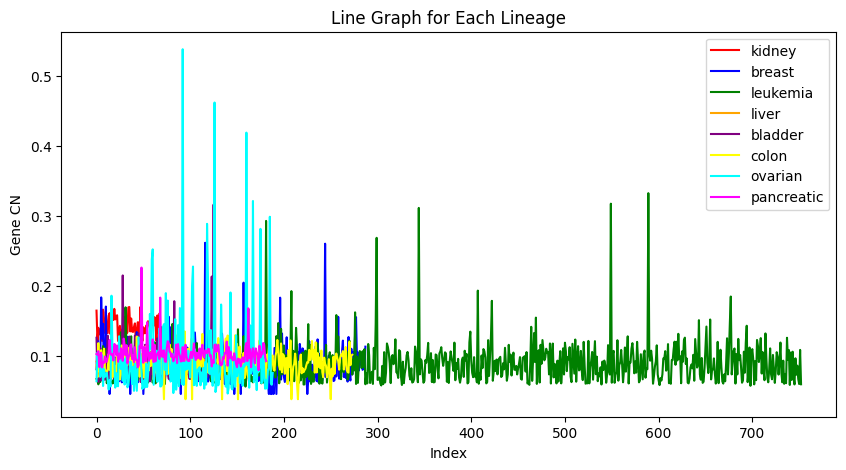

In [90]:
fig = plt.figure(figsize=(10, 5))
for i in range(len(training_dfs)):
    lineage = list(training_dfs.keys())[i]
    X = training_dfs[lineage].drop(['gene', 'label'], axis=1)
    Y = training_dfs[lineage]['label']
    accuracy, y_test, y_pred, y_pred_rt, model, auc_value, precision, recall, f1score  = trainLRmodel(X, Y)
    rounded_accuracy = round(float(accuracy), 3)
    # Assuming you have a dictionary 'lineage_df_dict' containing lineages as keys and dataframes as values

    # Create a list of colors for each lineage
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    # Plot a line graph for each lineage
    plt.plot(y_pred_rt, color=colors[i], label=lineage)

# Set the x-axis label
plt.xlabel('Index')

# Set the y-axis label
plt.ylabel('Gene CN')

# Set the title of the graph
plt.title('Line Graph for Each Lineage')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [36]:
print(accuracy)


0.8676470588235294
